## Step 1: Porting chippr from github:

This step demonstrates the initial setup for utilizing CHIPPR, using a direct port from my GitHub repository. It’s important to note that CHIPPR was originally written in Python 2 (as referenced in [link ]), while the version in my repository has been updated to Python 3. I have also addressed the associated errors during the transition.

In [1]:
!git clone https://github.com/AIstrophysics/chippr.git

fatal: destination path 'chippr' already exists and is not an empty directory.


In [2]:
%cd chippr

/home/jovyan/AST424/chippr


In [3]:
import sys
sys.path.append('/home/jovyan/AST424/chippr')

In [4]:
%cd /home/jovyan/AST424/chippr

/home/jovyan/AST424/chippr


In [5]:
pip install -r /home/jovyan/AST424/chippr/requirements.txt

  Using cached emcee-3.1.6-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached pomegranate-1.1.1-py3-none-any.whl.metadata (467 bytes)
  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached apricot_select-0.6.1-py3-none-any.whl
  Using cached nose-1.3.7-py3-none-any.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (

In [6]:
import sys
sys.path.append('/home/jovyan/AST424/chippr/chippr')
print(sys.path)

['/home/jovyan/AST424', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/AST424/chippr', '/home/jovyan/AST424/chippr/chippr']


## Step 2: Check the import of CHIPPR via printing the directory of CHIPPR.

You should be able to see all functions inside chippr using next line of code.

In [7]:
import chippr
print(dir(chippr))

['GD', 'GMM', 'ICD', 'MGD', 'ND', 'UD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'a_bfe', 'a_exp', 'a_int', 'a_map', 'a_mle', 'a_smp', 'a_stk', 'a_tbp', 'a_tru', 'acors', 'bisect', 'c_bfe', 'c_exp', 'c_int', 'c_map', 'c_mle', 'c_smp', 'c_stk', 'c_tbp', 'c_tru', 'calculate_kld', 'calculate_rms', 'cat_out_mean', 'cat_out_rate', 'cat_out_sigma', 'catalog', 'catalog_plots', 'cf', 'cfs', 'cft', 'check_basic_setup', 'check_bias_params', 'check_catastrophic_outliers', 'check_inf_params', 'check_sampler_params', 'check_sim_params', 'check_variable_sigmas', 'chippr', 'choice', 'cm', 'colors', 'constant_bias', 'constant_sigma', 'cpkl', 'csv', 'd', 'd_bfe', 'd_exp', 'd_int', 'd_map', 'd_mle', 'd_smp', 'd_stk', 'd_tbp', 'd_tru', 'defaults', 'discrete', 'dpi', 'emcee', 'eps', 'gamma', 'gauss', 'gmix', 'gr_test', 'gr_threshold', 'gridspec', 'ingest', 'l_bfe', 'l_exp', 'l_int', 'l_map', 'l_mle', 'l_smp', 'l_stk', 'l_tbp', 'l

/opt/conda/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import cProfile, pstats
from io import StringIO  #, StringIO in python2, changed for python3
import os

import chippr

## Step 3: Simulation: generate the mock catalog of individual posterior probability distributions.

To create a catalog, we must first define a true redshift distribution function. In this case, we will consider a mixture of three Gaussian distributions to represent the true redshift distribution.

In [9]:
true_amps = np.array([0.20, 0.35, 0.55])
true_means = np.array([0.5, 0.2, 0.75])
true_sigmas = np.array([0.4, 0.2, 0.1])
n_mix_comps = len(true_amps)

true_funcs = []
for c in range(n_mix_comps):
    true_funcs.append(chippr.gauss(true_means[c], true_sigmas[c]**2))

true_nz = chippr.gmix(funcs=true_funcs, amps=true_amps, limits=(0., 1.))
print(type(true_nz))

<class 'gmix.gmix'>


Input params.txt file, could be downloaded from Github: https://github.com/AIstrophysics/chippr/blob/master/docs/notebooks.

chippr supports the use of a parameter file to specify various options for the catalog simulator to turn on and off.

In [10]:
param_loc = '/home/jovyan/AST424/params.txt'
params = chippr.utils.ingest(param_loc)
params = chippr.defaults.check_sim_params(params) 
print(params)

{'n_gals': 3, 'n_bins': 10, 'bin_min': 0.0, 'bin_max': 1.0, 'variable_sigmas': 0, 'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'outlier_mean': 0.4, 'outlier_sigma': 0.075, 'gr_threshold': ['1.2'], 'catastrophic_outliers': 'template', 'n_accepted': ['3'], 'n_burned': ['2'], 'n_walkers': ['100'], 'ez_bias': False, 'ez_bias_val': 0.003, 'variable_bias': False}


To make the catalog, we need to input the implicit prior model n^*(z)=P(z|phi^*), as indicating in paper Figure 3 flowchart. By convolving defined implicit prior model with J posteriors P(z|data_j^+) to get the implicit posteriors {p(z | data_j^+, phi_*)}.

Discrete distribution- uniform distribution is used here as the implicit prior function.

In [11]:
bin_ends = np.array([params['bin_min'], params['bin_max']])
weights = np.array([1.])

int_prior = chippr.discrete(bin_ends, weights)

{'n_gals': 3, 'n_bins': 10, 'bin_min': 0.0, 'bin_max': 1.0, 'variable_sigmas': 0, 'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'outlier_mean': 0.4, 'outlier_sigma': 0.075, 'gr_threshold': ['1.2'], 'catastrophic_outliers': 'template', 'n_accepted': ['3'], 'n_burned': ['2'], 'n_walkers': ['100'], 'ez_bias': False, 'ez_bias_val': 0.003, 'variable_bias': False}
hor_amps shape torch.Size([20])
self.z_fine shape (20,)
int_pr_fine values: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
20
before coarsify: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)
int_pr_fine shape: (20,)
int_pr_coarse shape: (1, 10)
bin_ends shape: (11,)
after coarsify: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
x 

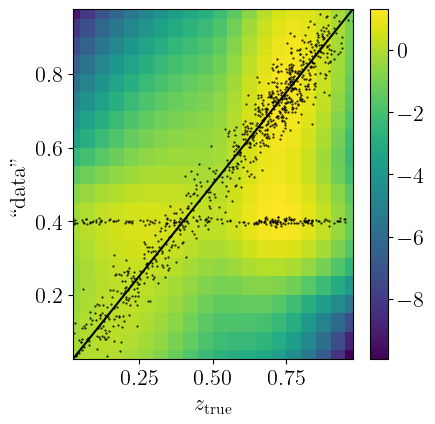

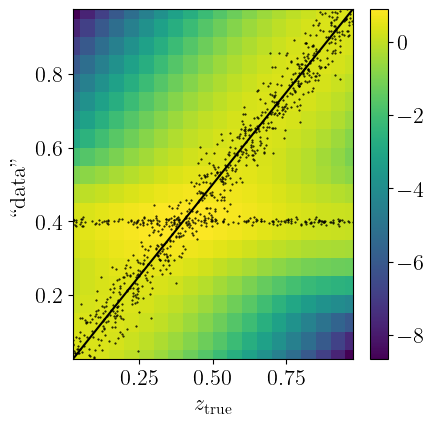

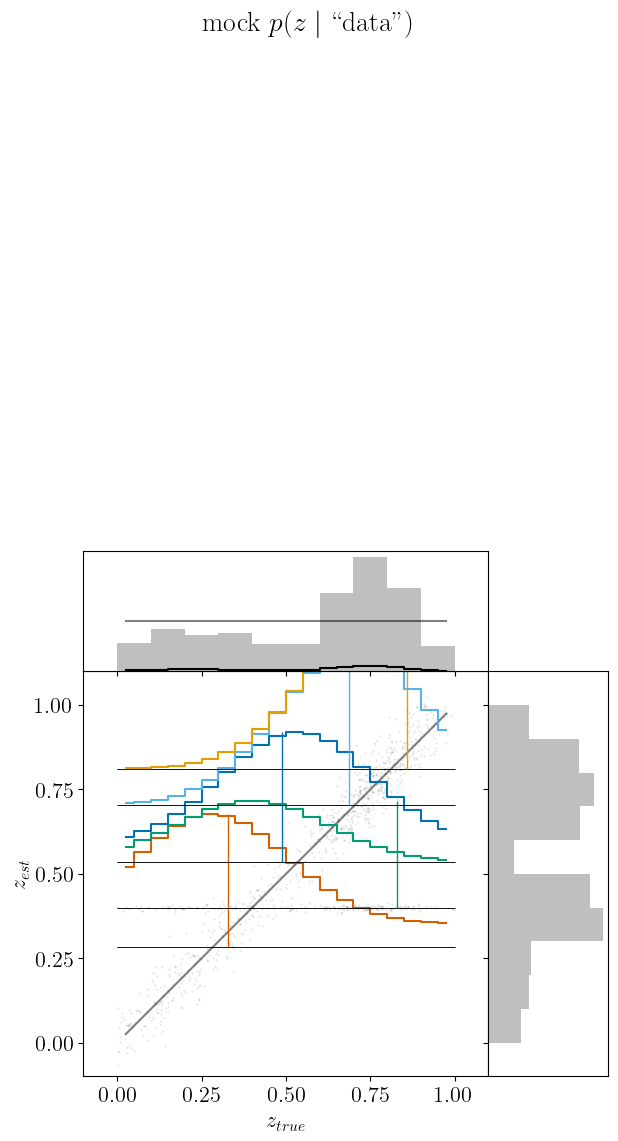

In [12]:
results_loc = os.path.join(os.path.join(os.path.join(os.path.join('..', '..'), 'research'), 'results'), 'demo')

posteriors = chippr.catalog(params=param_loc, loc=results_loc)

output = posteriors.create(true_nz, int_prior, N=params['n_gals'])

data = np.exp(output['log_interim_posteriors'])

In [13]:
interim_prior = np.exp(output['log_interim_prior'])[0]
x = np.exp(output['log_interim_posteriors'])
print(interim_prior)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Text(0.5, 0, 'z')

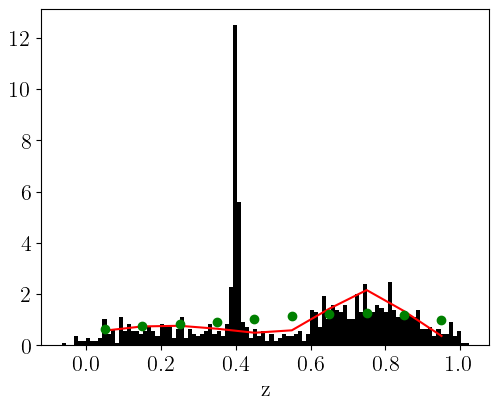

In [14]:
plt.hist(posteriors.samps.T[1], bins=100, density=True, color="k")
plt.plot(posteriors.z_coarse, true_nz.evaluate(posteriors.z_coarse), "r-")
plt.plot(posteriors.z_coarse, np.sum(data, axis=0) / 10**params['n_gals'], "go")
plt.xlabel("z")

It is also informative to see what a few individual likelihoods and binned posteriors look like. The prior has also been added on the plot because of the simplified bayesian relationship: posterior ~ likelihood * prior. When using the original CHIPPR input directly, we observe significant variation between the likelihood and posterior functions, where the prior is set to 1. This occurs because the author manually normalized the prior distribution without addressing the proportionality constant.

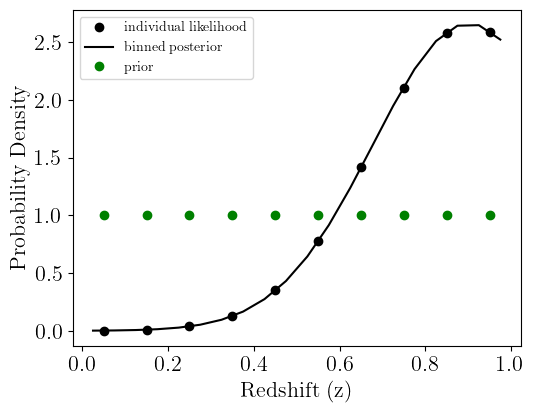

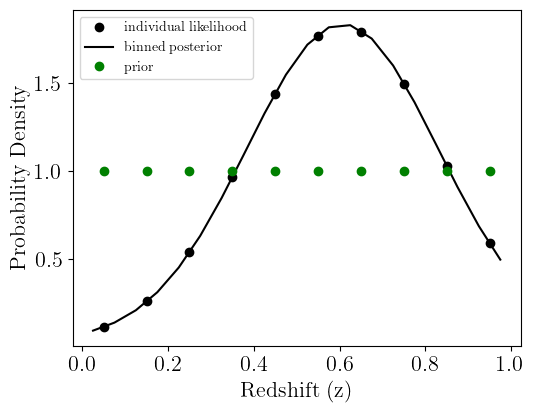

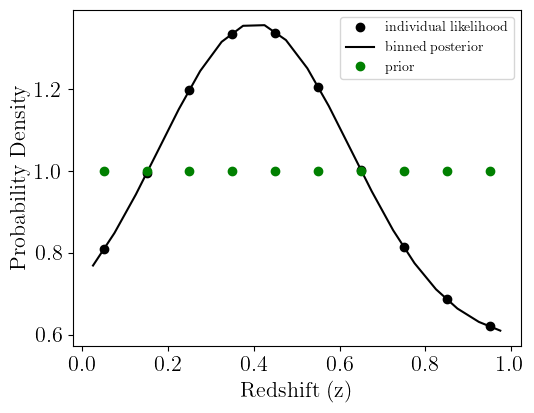

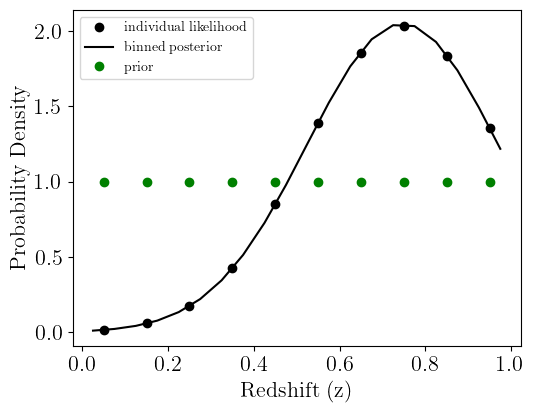

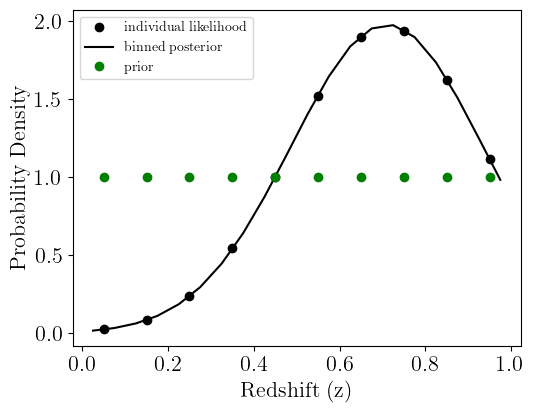

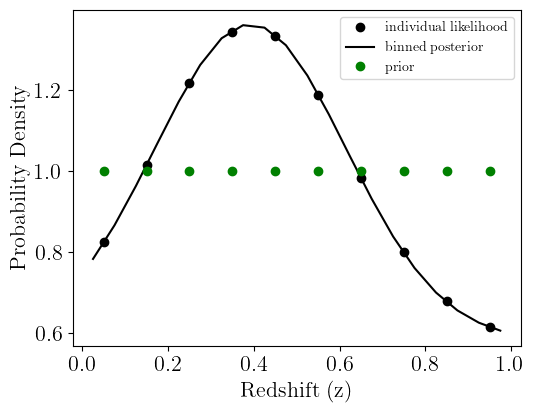

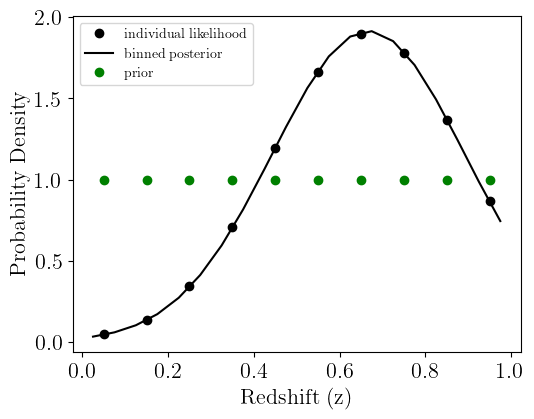

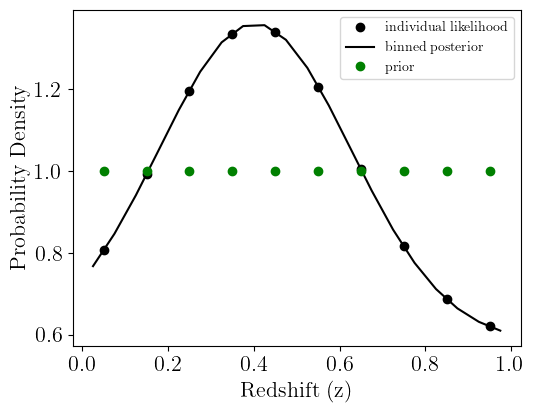

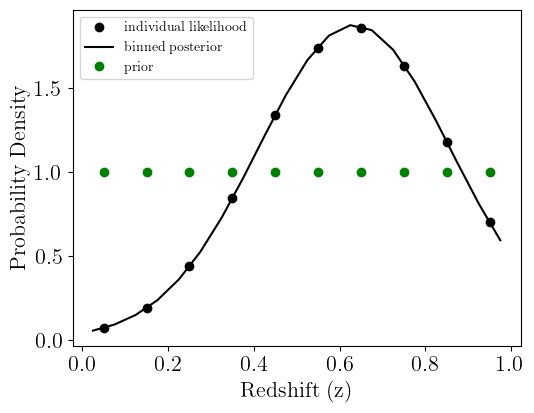

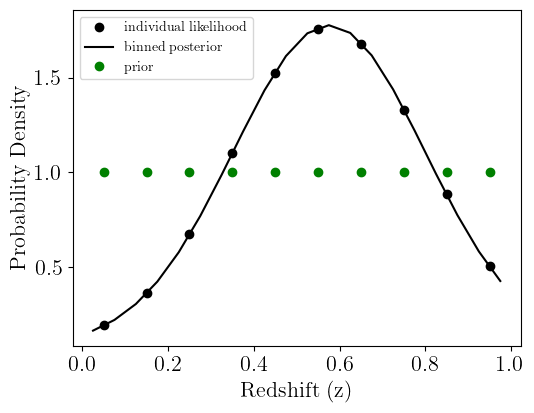

In [15]:
for n, z in enumerate(data[:10]):
    plt.plot(posteriors.z_coarse, data[n], 'ko',label='individual likelihood') #individual likelihoods
    plt.plot(posteriors.z_fine, posteriors.obs_lfs[n], 'k-',label='binned posterior')#binned posterior
    plt.plot(posteriors.z_coarse, interim_prior, 'go',label='prior') #prior
    
    
    plt.xlabel('Redshift (z)') 
    plt.ylabel('Probability Density')  
    plt.legend() 
    plt.show() 

Saving the catalog for the following inference. 

In [16]:
saved_location = 'data'
saved_type = '.txt'
posteriors.write(loc=saved_location, style=saved_type)

In [17]:
param_loc = '/home/jovyan/AST424/params.txt'
results_loc = os.path.join(os.path.join(os.path.join(os.path.join('..', '..'), 'research'), 'results'), 'demo')
simulated_posteriors = chippr.catalog(params=param_loc, loc=results_loc)

data_update = simulated_posteriors.read(loc=saved_location, style=saved_type)
print(data_update)

{'n_gals': 3, 'n_bins': 10, 'bin_min': 0.0, 'bin_max': 1.0, 'variable_sigmas': 0, 'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'outlier_mean': 0.4, 'outlier_sigma': 0.075, 'gr_threshold': ['1.2'], 'catastrophic_outliers': 'template', 'n_accepted': ['3'], 'n_burned': ['2'], 'n_walkers': ['100'], 'ez_bias': False, 'ez_bias_val': 0.003, 'variable_bias': False}
{'bin_ends': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'log_interim_prior': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'log_interim_posteriors': array([[-6.19353024e+00, -4.60908924e+00, -3.22247100e+00, ...,
         7.45585289e-01,  9.46516979e-01,  9.49946028e-01],
       [-2.17031252e+00, -1.35166507e+00, -6.14522559e-01, ...,
         4.03090993e-01,  3.07739358e-02, -5.25741579e-01],
       [-2.12718260e-01, -5.80690491e-03,  1.79790536e-01, ...,
        -2.05037818e-01, -3.75170415e-01, -4.77380985e-01],
       ...,
       [-3.52133978e+00, -2.34121635e+00, -1.35141070e+00, ...,
         6.4669

## Step 4: Inference

chippr currently contains one inference module to probe the posterior distribution of parameters defining the redshift distribution function.
To perform inference, we must create a catalog object. This may be done by making a new catalog as is done above or by reading in an existing catalog file.

The catalog file contains three components: the bin_ends, the log_interim_prior, and the log_interim_posteriors. The bin endpoints can be processed to enable their use in constructing a prior distribution over the parameters determining the redshift distribution function.

In [18]:
zs = data_update['bin_ends']
log_nz_intp = data_update['log_interim_prior']
#log_nz_intp = prior_test
print(log_nz_intp)
log_z_posts = data_update['log_interim_posteriors']
print(len(log_z_posts))

z_difs = zs[1:]-zs[:-1]
z_mids = (zs[1:]+zs[:-1])/2.
n_bins = len(z_mids)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1000


## Note:
mvn.py function, which was utilized following, has been edited because of the error: TypeError: '>' not supported between instances of 'tuple' and 'float', extract the eigenvalue value first. See edited mvn function. 

In this case, the prior distribution has been considered a mvn object, defined by a mean vector and covariance matrix over the parameters defining the redshift distribution. It is intuitive to use the definition of the binning strategy to create the prior distribution since the parameters are normalized histogram bin heights, the same parametrization used for the catalog entries themselves.

The exact distribution of prior distribution may vary depending on specific catalogs.

In [19]:
# prior_sigma = 0.16
# prior_var = np.eye(n_bins)
# for b in range(n_bins):
#     prior_var[b] = 1. * np.exp(-0.5 * (z_mids[b] - z_mids) ** 2 / prior_sigma ** 2)
# l = 1.e-4
# prior_var = prior_var+l*np.identity(n_bins)


a = 1.# / n_bins
b = 20.#1. / z_difs ** 2
c = 0.
prior_var = np.eye(n_bins)
for k in range(n_bins):
    prior_var[k] = a * np.exp(-0.5 * b * (z_mids[k] - z_mids) ** 2)
prior_var += c * np.identity(n_bins)

prior_mean = log_nz_intp
prior = chippr.mvn(prior_mean, prior_var)

Error from inconsistence arguments of np.sum(fine_n) from ~/AST424/chippr/chippr/log_z_dens.py:81. 

See edited log_z_dens.py file.


We create a log_z_dens object from the dictionary of catalog parameters and the prior distribution. We include the optional specification of the true distribution, since it is available in this case.

10 bins, 1000 interim posterior PDFs


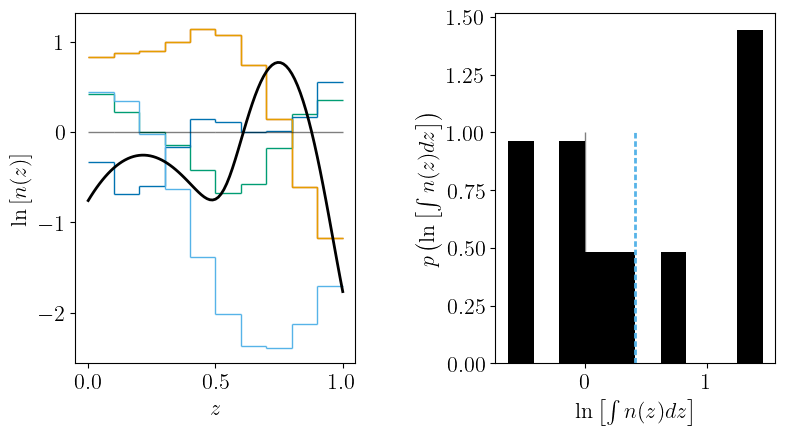

In [20]:
true_nz = chippr.gmix(funcs=true_funcs, amps=true_amps, limits=(0., 1.))
nz = chippr.log_z_dens(data_update, prior, truth=true_nz, vb=True)

prior_samples = prior.sample(10)
chippr.log_z_dens_plots.plot_ivals(prior_samples, nz.info, nz.plot_dir)

To evaluate the performance of CHIPPR, we compare it (using the MMLE of the full log-posterior distribution P(phi|{d_j}))with two other methods for estimating the redshift distribution: stacking and point estimation. The stacked estimator is defined as: f_stack(z;phi_^ ) = sum(P(z|dj,phi^*)), Stacking the modified photo-z implicit posteriors leads to the marginalized maximum a posteriori (MMAP) estimator and the marginalized expected value (MExp) estimator.

In [21]:
nz_stacked = nz.calculate_stacked()
nz_mmap = nz.calculate_mmap()
nz_mexp = nz.calculate_mexp()

Ensure input z is 2dim from mvn.evaluate_one function.

The log_z_dens object enables easy comparison between estimators using the Kullback-Leibler Divergences (when the true distribution is available) and root-mean-square differences.
We may next calculate the marginalized maximum likelihood estimator (which actually returns the parameters maximizing the posterior probability).

In [22]:
nz_mmle = nz.calculate_mmle(nz_stacked)

optimizing posterior
. starting at  [-0.42528438 -0.27256276 -0.16436242 -0.07346778  0.02323873  0.12536029
  0.20587283  0.22770533  0.16111486 -0.00884888] [-80.90995158]
.:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -155.46119945520374
             x: [ 3.202e-01  7.886e-01  1.126e+00  1.395e+00  1.843e+00
                  2.477e+00  2.844e+00  2.439e+00  1.312e+00  7.729e-02]
           nit: 1999
          nfev: 2818
 final_simplex: (array([[ 3.202e-01,  7.886e-01, ...,  1.312e+00,
                         7.729e-02],
                       [ 3.202e-01,  7.886e-01, ...,  1.312e+00,
                         7.729e-02],
                       ...,
                       [ 3.202e-01,  7.886e-01, ...,  1.312e+00,
                         7.729e-02],
                       [ 3.202e-01,  7.886e-01, ...,  1.312e+00,
                         7.728e-02]]), array([-1.555e+02, -1.555e+02, -1.555e+02, -1.555e+02,
             

If we are very ambitious, we can run an MCMC sampler (currently use of emcee is supported, but other samplers may be added in the future) to probe the posterior distribution of the parameter values. To do this, we initialize the sampler with samples from the prior distribution.


100
beginning sampling 0
Gelman-Rubin test statistic = [1.96198619 1.85070458 1.83932216 1.86502806 1.80639585 1.86168603
 1.82312914 1.83105714 1.92731918 1.91454756]
beginning sampling 1
Gelman-Rubin test statistic = [1.66440089 1.61041867 1.45413421 1.56127504 1.60334355 1.57618446
 1.52945899 1.54462324 1.57262326 1.50705656]
beginning sampling 2
Gelman-Rubin test statistic = [1.44998134 1.43627295 1.40852253 1.42385907 1.44958801 1.476618
 1.38971251 1.52075142 1.4326264  1.39765969]
beginning sampling 3
Gelman-Rubin test statistic = [1.27102128 1.32970805 1.31546245 1.22917417 1.24990966 1.28900075
 1.31060933 1.24539893 1.32420098 1.32169287]
beginning sampling 4
Gelman-Rubin test statistic = [1.19658003 1.23881275 1.22377671 1.18048355 1.18831768 1.20735438
 1.22089653 1.19218551 1.2608109  1.28020201]
beginning sampling 5
Gelman-Rubin test statistic = [1.18522179 1.20424244 1.20533788 1.17126188 1.16772068 1.17741886
 1.17792117 1.17292089 1.21062252 1.21954732]
beginning samp

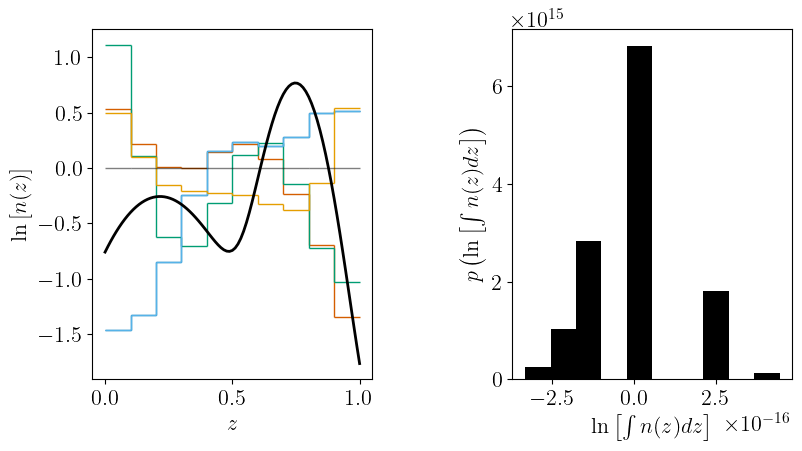

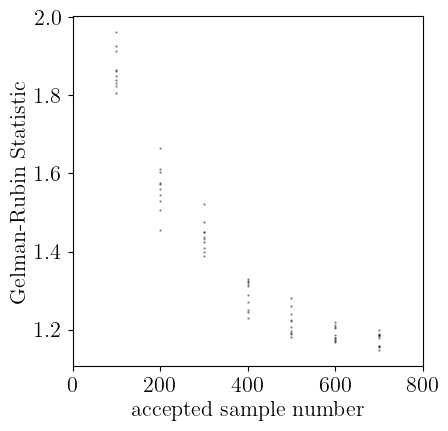

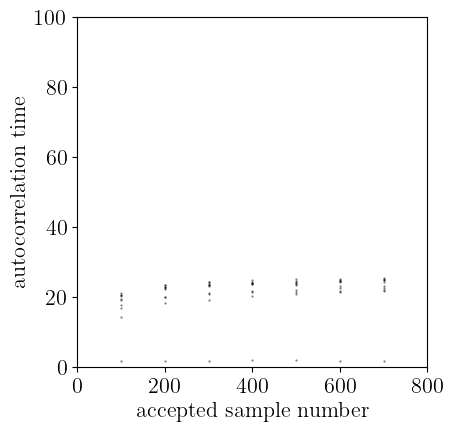

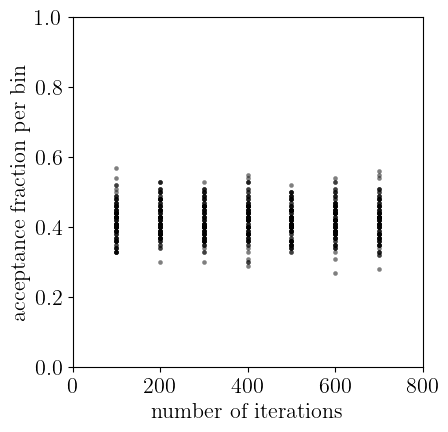

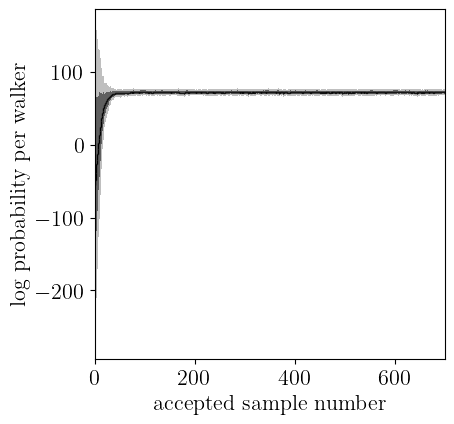

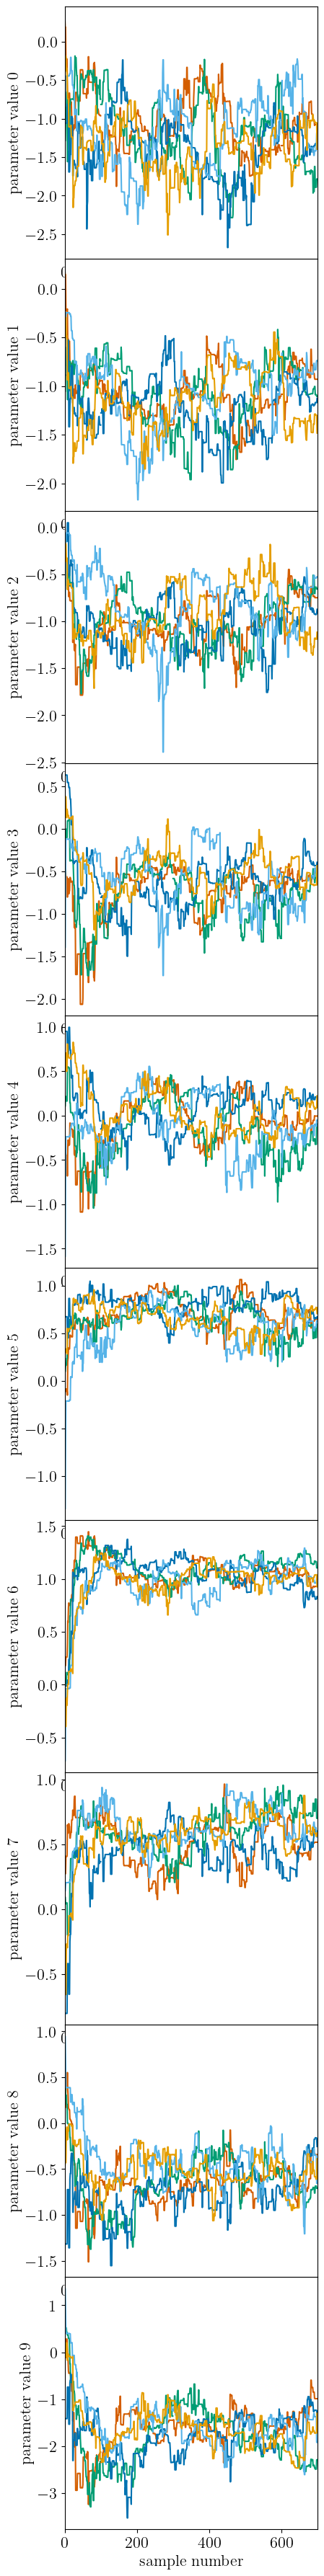

In [23]:
n_ivals = 10*n_bins
print(n_ivals)
initial_values = prior.sample(n_ivals)

nz_samps = nz.calculate_samples(initial_values)

Editing for listing index in log_z_dens.compare(self, vb) with error: TypeError: 'dict_keys' object is not subscriptable. Check for the log_z_dens.compare(self, vb) file. 

In [24]:
nz_stats = nz.compare()

{'kld': {'log_stacked_nz': 0.08544565339397128, 'log_mmap_nz': 0.11225039761689647, 'log_mexp_nz': 76.32072986854517, 'log_mmle_nz': 0.21534170661450652, 'log_mean_sampled_nz': 0.25792424985607953}, 'log_kld': {}, 'rms': {'true_nz__stacked_nz': 0.44696246820094687, 'true_nz__mmap_nz': 0.510934260302549, 'true_nz__mexp_nz': 0.9526620134486824, 'true_nz__mmle_nz': 0.6782789062203677, 'true_nz__mean_sampled_nz': 0.7389240041014743, 'mmap_nz__stacked_nz': 0.40435201675929955, 'mexp_nz__stacked_nz': 0.9323901682825015, 'mexp_nz__mmap_nz': 0.8337145794575026, 'mmle_nz__stacked_nz': 0.6953701410451971, 'mmle_nz__mmap_nz': 0.8133437638715992, 'mmle_nz__mexp_nz': 0.8543453622011904, 'mean_sampled_nz__stacked_nz': 0.7464559827761921, 'mean_sampled_nz__mmap_nz': 0.8717979859889756, 'mean_sampled_nz__mexp_nz': 0.8927264857839016, 'mean_sampled_nz__mmle_nz': 0.0751682226366594}, 'log_rms': {'log_true_nz__log_stacked_nz': 0.4222109316707873, 'log_true_nz__log_mmap_nz': 0.5064260097188815, 'log_true_

In [25]:
nz.info['estimators'].keys()

dict_keys(['log_stacked_nz', 'log_mmap_nz', 'log_mexp_nz', 'log_mmle_nz', 'log_mean_sampled_nz'])

{'kld': {'log_stacked_nz': 0.08544565339397128, 'log_mmap_nz': 0.11225039761689647, 'log_mexp_nz': 76.32072986854517, 'log_mmle_nz': 0.21534170661450652, 'log_mean_sampled_nz': 0.25792424985607953}, 'log_kld': {}, 'rms': {'true_nz__stacked_nz': 0.44696246820094687, 'true_nz__mmap_nz': 0.510934260302549, 'true_nz__mexp_nz': 0.9526620134486824, 'true_nz__mmle_nz': 0.6782789062203677, 'true_nz__mean_sampled_nz': 0.7389240041014743, 'mmap_nz__stacked_nz': 0.40435201675929955, 'mexp_nz__stacked_nz': 0.9323901682825015, 'mexp_nz__mmap_nz': 0.8337145794575026, 'mmle_nz__stacked_nz': 0.6953701410451971, 'mmle_nz__mmap_nz': 0.8133437638715992, 'mmle_nz__mexp_nz': 0.8543453622011904, 'mean_sampled_nz__stacked_nz': 0.7464559827761921, 'mean_sampled_nz__mmap_nz': 0.8717979859889756, 'mean_sampled_nz__mexp_nz': 0.8927264857839016, 'mean_sampled_nz__mmle_nz': 0.0751682226366594}, 'log_rms': {'log_true_nz__log_stacked_nz': 0.4222109316707873, 'log_true_nz__log_mmap_nz': 0.5064260097188815, 'log_true_

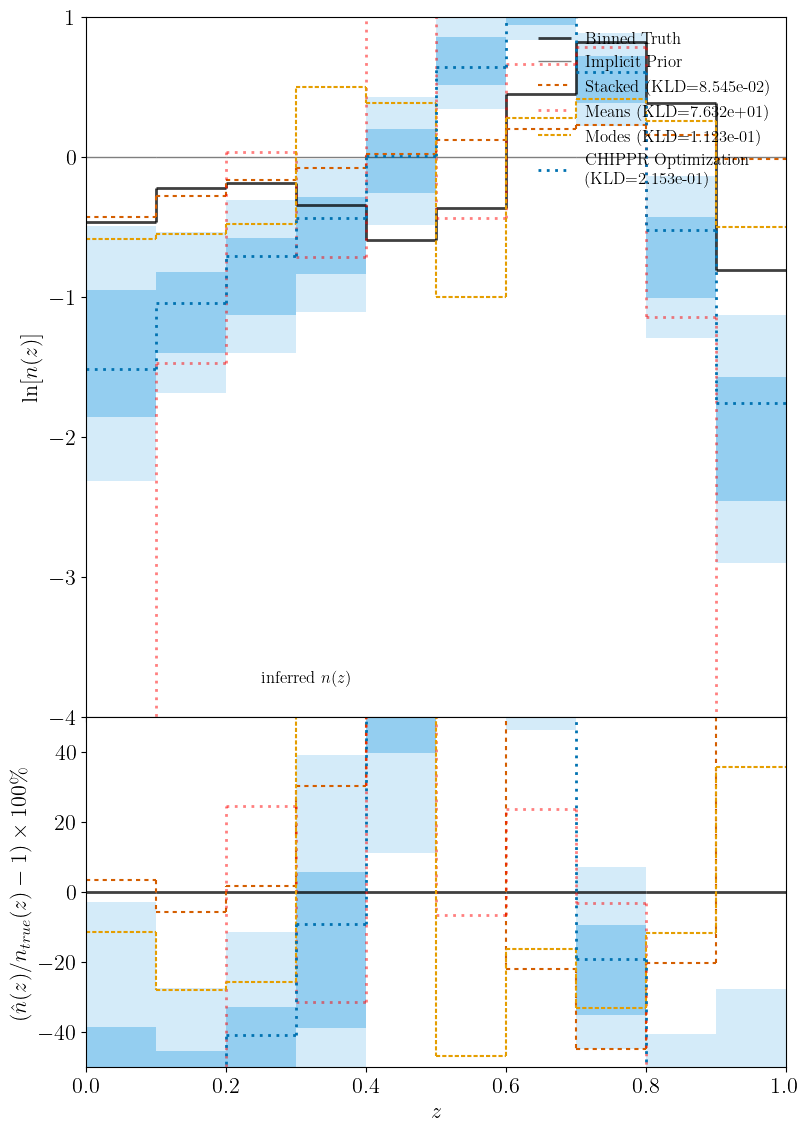

In [26]:
nz.plot_estimators()